In [ ]:
!mkdir -p kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vedantsk","key":"a35a70a8b25f91b444131047736525e1"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d jessicali9530/celeba-dataset

Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
License(s): other
 94% 1.25G/1.33G [00:15<00:01, 46.8MB/s]
100% 1.33G/1.33G [00:15<00:00, 93.5MB/s]


In [ ]:
!unzip -q /content/celeba-dataset.zip

In [ ]:
!pip3 install tensorflow numpy matplotlib seaborn keras pandas os



import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
import seaborn as sns
import glob
import imageio
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
import time
from IPython import display
import os
import time
import PIL

ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os


In [ ]:
base_dir = "/content/img_align_celeba/img_align_celeba"

In [ ]:
len(os.listdir(base_dir))

202599

In [ ]:
# prompt: import cv2

!pip install opencv-python
import cv2

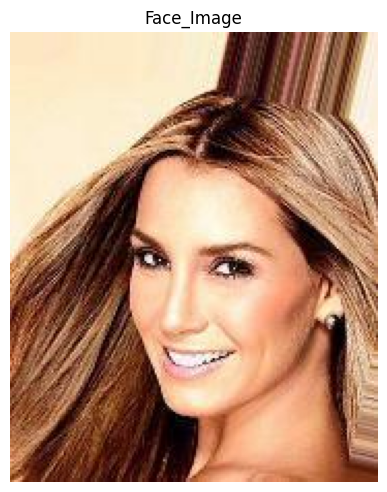

In [ ]:
sample_img = "/content/img_align_celeba/img_align_celeba/000001.jpg"
img = cv2.imread(sample_img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.axis("off")
plt.tight_layout()
plt.title("Face_Image")
plt.imshow(img)


In [ ]:
print(img.shape)

(218, 178, 3)


In [ ]:
def Random_image_generator(base_dir):


  image_files = glob.glob(os.path.join(base_dir, "*.jpg"))
  fig = plt.figure(figsize=(10,12))

  for i in range(12):

    img_path = np.random.choice(image_files)
    image = imageio.imread(img_path)

    plt.subplot(6,6,i+1)
    plt.axis("off")
    plt.imshow(image)

  plt.tight_layout()
  plt.show()

<ipython-input-12-3776797196>:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(img_path)


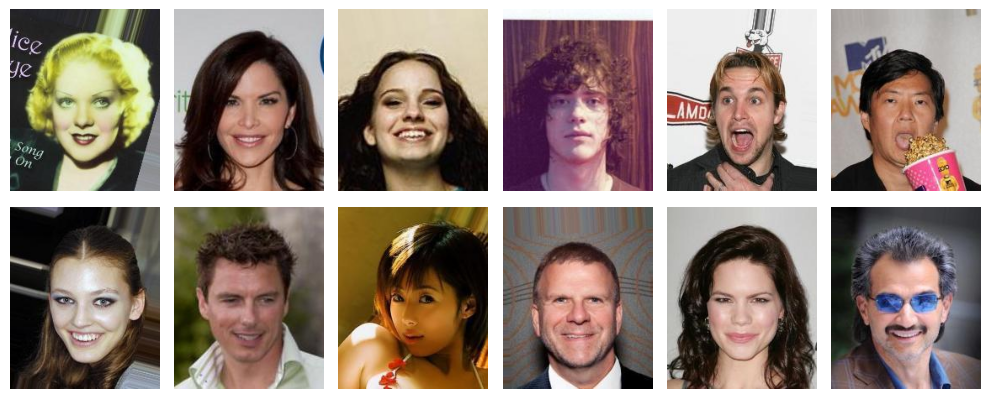

In [ ]:
Random_image_generator(base_dir)

# **LOADING IMAGES**

In [ ]:
def load_and_preprocess_images(base_dir, image_size=(64, 64), num_images=None):
    image_files = glob.glob(os.path.join(base_dir, "*.jpg"))
    # Limit the number of images if num_images is specified
    if num_images is not None:
        image_files = image_files[:num_images]

    all_images = []
    print(f"Loading and preprocessing {len(image_files)} images...")
    for i, img_path in enumerate(image_files):
        if (i + 1) % 1000 == 0:
            print(f"Processed {i + 1}/{len(image_files)} images.")
        try:
            preprocessed_image = readImage(img_path, image_size)
            all_images.append(preprocessed_image)
        except Exception as e:
            print(f"Error processing image {img_path}: {e}")
            pass
    return np.array(all_images)

In [ ]:
def readImage(path,image_size=(64,64)):
    train_image_pil = PIL.Image.open(path).resize(image_size)
    train_image = np.asarray(train_image_pil)

    train_image = ((train_image - 127.5) / 127.5).astype("float32")
    return train_image


train_image = load_and_preprocess_images(base_dir, num_images=10000)


Loading and preprocessing 10000 images...
Processed 1000/10000 images.
Processed 2000/10000 images.
Processed 3000/10000 images.
Processed 4000/10000 images.
Processed 5000/10000 images.
Processed 6000/10000 images.
Processed 7000/10000 images.
Processed 8000/10000 images.
Processed 9000/10000 images.
Processed 10000/10000 images.


In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_image).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# **GENERATOR model**

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()

    # Latent vector to (4x4x512)
    model.add(layers.Dense(4*4*512, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((4, 4, 512)))  # Now: (4,4,512)

    # 8x8x256
    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # 16x16x128
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # 32x32x64
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # 64x64x3 - final output
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same',
                                     use_bias=False, activation='tanh'))

    return model

# Create and summarize
generator = make_generator_model()
generator.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 8192)           │       819,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 8192)           │        32,768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 256)      │     3,276,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 128)    │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 64, 64, 3)      │         4,800 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,159,360 (19.68 MB)

 Trainable params: 5,142,080 (19.62 MB)

 Non-trainable params: 17,280 (67.50 KB)

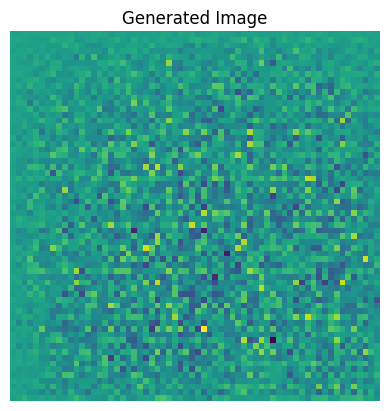

In [ ]:
#generate sample image to test the generator
noise = tf.random.normal([1,100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0])
plt.title("Generated Image")
plt.axis("off")
plt.show()

# **Discriminator model**

In [ ]:
def make_discriminator():
    model = tf.keras.Sequential()

    # Changed input_shape to match the processed image size (64, 64, 3)
    model.add(layers.Conv2D(64,(5,5),strides=(2,2),padding="same",input_shape=(64,64,3)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128,(5,5),strides=(2,2),padding="same"))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256,(5,5),strides=(2,2),padding="same"))
    model.add(layers.LeakyReLU())


    model.add(layers.Conv2D(512,(5,5),strides=(2,2),padding="same"))
    model.add(layers.LeakyReLU())


    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

# Recreate the discriminator model with the corrected input shape
discriminator = make_discriminator()
discriminator.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 256)      │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 512)      │     3,277,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,314,753 (16.46 MB)

 Trainable params: 4,314,753 (16.46 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)



---
Generative Adversarial Network (GAN) to generate fake human faces, and you are testing your untrained discriminator on a randomly generated image from your untrained generator, then getting a negative value from the discriminator is a good initial sign.


---





# **LOSS CALC**

In [ ]:

def discriminator_loss(real_output, fake_output):
    real_labels = tf.random.uniform(shape=tf.shape(real_output), minval=0.8, maxval=1.0)
    fake_labels = tf.random.uniform(shape=tf.shape(fake_output), minval=0.0, maxval=0.2)

    real_loss = cross_entropy(real_labels, real_output)
    fake_loss = cross_entropy(fake_labels, fake_output)

    total_loss = real_loss + fake_loss
    return total_loss


In [ ]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
# intialize optimizor

generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

In [ ]:
checkpt_dir = './training_checkpoints'
checkpt_prefix = os.path.join(checkpt_dir, "ckpt")

if not os.path.exists(checkpt_dir):
  os.makedirs(checkpt_dir)

checkpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                               discriminator_optimizer=discriminator_optimizer,
                               generator=generator,
                               discriminator=discriminator)

**epochs**

In [ ]:
EPOCHS = 200
noise_dim = 100
nums_examples_to_generate = 16

seed = tf.random.normal([nums_examples_to_generate , noise_dim])

training steps

In [ ]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # 1. Generate fake images
        generated_images = generator(noise, training=True)

        # 2. Discriminator evaluates real and fake images
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        # 3. Calculate losses
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # 4. Apply gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

def generate_and_save_images(model, epoch, test_input, save_dir='generated_images'):

    # Generate predictions
    predictions = model(test_input, training=False)
    predictions = (predictions + 1) / 2.0  # Rescale from [-1, 1] to [0, 1]

    # Create directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)

    # Set up the plot
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i])
        plt.axis('off')

    # Save to disk
    filename = os.path.join(save_dir, f"image_at_epoch_{epoch:04d}.png")
    plt.savefig(filename)
    plt.close(fig)  # Close to avoid memory overload


#TRAINING FUNC

In [ ]:
# training function to run training loop

def train(epochs):
  for epoch in range(epochs):
    start = time.time()

    #iterate every batch
    for image_batch in train_dataset:
      train_step(image_batch)

    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      # Corrected the variable name from checkpoint_prefix to checkpt_prefix
      checkpt.save(file_prefix = checkpt_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

train(EPOCHS)

Time for epoch 200 is 16.904242992401123 sec


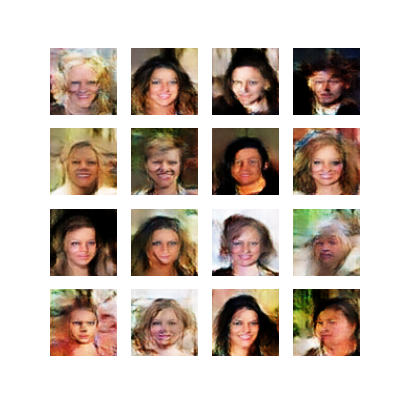

In [ ]:
checkpt.restore(tf.train.latest_checkpoint(checkpt_dir))

def display_image(epoch_no, save_dir='generated_images'):

  # Construct the full path to the image file
  filename = os.path.join(save_dir, f"image_at_epoch_{epoch_no:04d}.png")
  return PIL.Image.open(filename)

# Call display_image with the correct directory
display_image(EPOCHS, save_dir='generated_images')


In [ ]:

import glob

image_paths = glob.glob(base_dir+"/*")
anim_file = 'gan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:

  filenames = glob.glob('generated_images/image_at_epoch_*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)


<ipython-input-30-376822687>:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


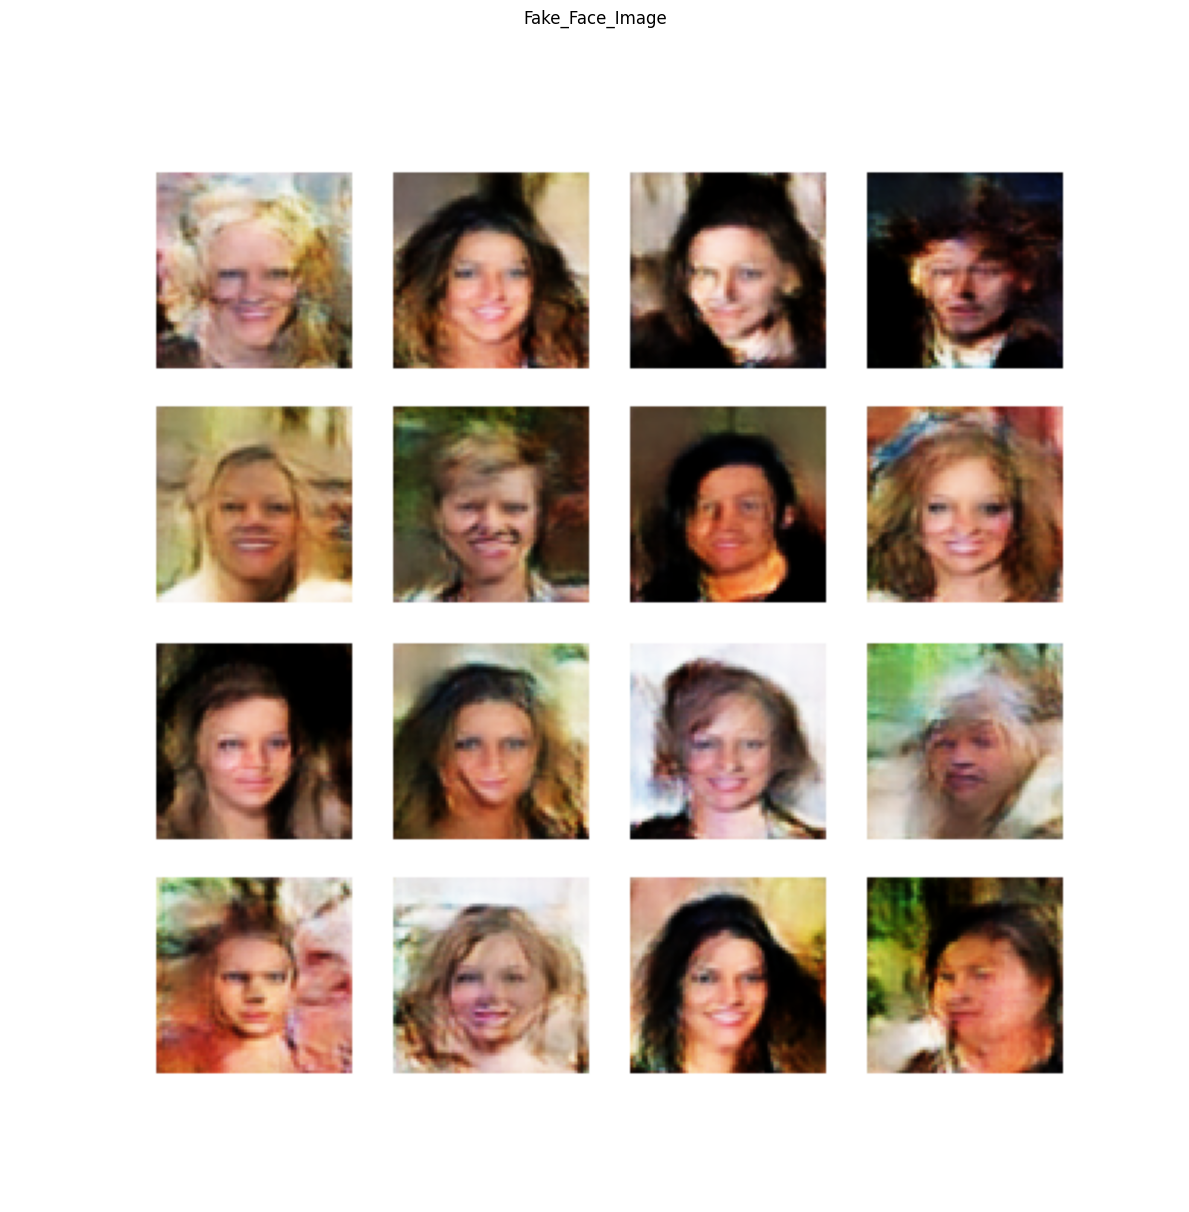

In [ ]:
sample1_img = "/content/generated_images/image_at_epoch_0200.png"

img = cv2.imread(sample1_img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

fig = plt.figure(figsize=(12,14))

plt.axis("off")
plt.tight_layout()
plt.title("Fake_Face_Image")
plt.imshow(img)

In [ ]:
# prompt: save generator model .keras

generator.save("generator_model.keras")